In [1]:
from lib.dependencies import *
from lib.time_series_dependencies import *
from lib.models import *
import os
import timeit

In [2]:
# modes
gp = True
sn = False

# steps
train = False
eph = '2999' # if not in training mode, specify a epoch of model to load
fixed_input = True

# specifications
MODE = 'wgan-sn'  # wgan or wgan-gp
DATASET = 'pollution'  # 8gaussians, sine, heteroscedastic, moon
suffix = '_gp_lat64_20'
DIM = 512  # 512 Model dimensionality
LATENT_DIM = 64 # latent space dimension
ntimes = 20 # window length for the GAN
nvars = 7 # number of variables in time series data
INPUT_DIM = ntimes*nvars # input dimension
LAMBDA = 0.1  # Smaller lambda seems to help for toy tasks specifically
DROPOUT_RATE = 0.1 # dropout rate for GAN
lr = 1e-4 # learning rate for training GAN
CRITIC_ITERS = 5  # How many critic iterations per generator iteration
BATCH_SIZE = 140  # 256 Batch size
ITERS = 5000  # how many generator iterations to train for
log_interval = 1000 # how frequent to write to log and save models 
use_cuda = False

DATA_PATH = '/Users/wendyhsu/Documents/ACSE/ACSE_9/data/'
DATA_NAME = 'pollution_one_day.csv'
# DATA_NAME = 'pollution_one_day2.csv'
 
TMP_PATH = 'tmp/' + DATASET + suffix + '/'
if not os.path.isdir(TMP_PATH):
    os.makedirs(TMP_PATH)

In [3]:
netG = Generator(LATENT_DIM, DIM, DROPOUT_RATE, INPUT_DIM)
if sn:
    netD = DiscriminatorSNTime(DIM, INPUT_DIM, BATCH_SIZE)
else:
    netD = DiscriminatorTime(DIM, INPUT_DIM, BATCH_SIZE)

netG.apply(weights_init)
netD.apply(weights_init)

# read data
df, scaler = read_data(DATA_PATH+DATA_NAME)

Reading data file: /Users/wendyhsu/Documents/ACSE/ACSE_9/data/pollution_one_day.csv


In [4]:
if train:
    # start writing log
    f = open(TMP_PATH + "log.txt", "w")
    # print specifications
    f.write('gradient penalty: ' + str(gp))
    f.write('\n spectral normalization: ' + str(sn))
    f.write('\n datasest: ' + DATASET)
    f.write('\n hidden layer dimension: ' + str(DIM))
    f.write('\n latent space dimension: ' + str(LATENT_DIM))
    f.write('\n gradient penalty lambda: ' + str(LAMBDA))
    f.write('\n dropout rate: ' + str(DROPOUT_RATE))
    f.write('\n critic iterations per generator iteration: ' + str(CRITIC_ITERS))
    f.write('\n batch size: ' + str(BATCH_SIZE))
    f.write('\n total iterations: ' + str(ITERS))
    f.write('\n')
    # print model structures
    f.write(str(netG))
    f.write(str(netD))
    f.write('\n')

    if use_cuda:
        netD = netD.cuda()
        netG = netG.cuda()
    
    optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.9))
    optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.9))
    
    one = torch.FloatTensor([1])
    mone = one * -1
    if use_cuda:
        one = one.cuda()
        mone = mone.cuda()
    
    # create time window data
    X_train = torch.Tensor(concat_timesteps(df, ntimes, 1, df.shape[0]))
    
    losses = []
    wass_dist = []
    
    # start timing
    start = timeit.default_timer()
    batch = 0
    
    for iteration in range(ITERS):
        while (batch+1)*BATCH_SIZE <= X_train.shape[0]:
            ############################
            # (1) Update D network
            ###########################
            for iter_d in range(CRITIC_ITERS):
                if (batch+1)*BATCH_SIZE  <= X_train.shape[0]:
                    # _data = next(data).float()
                    _data = X_train[batch*BATCH_SIZE:(batch+1)*BATCH_SIZE, :, :]
                    batch += 1
                    if use_cuda:
                        _data = _data.cuda()
            
                    netD.zero_grad()
            
                    # train with real
                    D_real = netD(_data)
                    D_real = D_real.mean().unsqueeze(0)
                    D_real.backward(mone)
            
                    # train with fake
                    noise = torch.randn(BATCH_SIZE, LATENT_DIM)
                    if use_cuda:
                        noise = noise.cuda()
                    fake = netG(noise)
                    D_fake = netD(fake.detach())
                    D_fake = D_fake.mean().unsqueeze(0)
                    D_fake.backward(one)
            
                    # train with gradient penalty
                    if gp:
                        gradient_penalty = calc_gradient_penalty(netD, _data.view(-1, BATCH_SIZE, INPUT_DIM), fake, BATCH_SIZE, LAMBDA, use_cuda)
                        gradient_penalty.backward()
                    
                    if gp:
                        D_cost = abs(D_fake - D_real) + gradient_penalty
                    else:
                        D_cost = abs(D_fake - D_real)
                        
                    Wasserstein_D = abs(D_real - D_fake)
                    optimizerD.step()
        
            ############################
            # (2) Update G network
            ############################
            netG.zero_grad()
            if (batch+1)*BATCH_SIZE  <= X_train.shape[0]:
                    _data = X_train[batch*BATCH_SIZE:(batch+1)*BATCH_SIZE, :, :]

            if use_cuda:
                _data = _data.cuda()
        
            noise = torch.randn(BATCH_SIZE, LATENT_DIM)
            
            if use_cuda:
                noise = noise.cuda()
            fake = netG(noise)
            G = netD(fake)
            G = G.mean().unsqueeze(0)
            G.backward(mone)
            G_cost = -G
            optimizerG.step()
            
            losses.append([G_cost.cpu().item(), D_cost.cpu().item()])
            wass_dist.append(Wasserstein_D.cpu().item())
            
        # reset batch 
        batch = 0

        if iteration % log_interval == log_interval - 1:
            # save discriminator model
            torch.save(netD.state_dict(), TMP_PATH + 'disc_model' + str(iteration) + '.pth')
            # save generator model
            torch.save(netG.state_dict(), TMP_PATH + 'gen_model' + str(iteration) + '.pth')
            # report iteration number
            f.write('Iteration ' + str(iteration) + '\n')
            # report time
            stop = timeit.default_timer()
            f.write('    Time spent: ' + str(stop - start) + '\n')
            # report loss
            f.write('    Generator loss: ' + str(G_cost.cpu().item()) + '\n')
            f.write('    Discriminator loss: ' + str(D_cost.cpu().item()) + '\n')
            f.write('    Wasserstein distance: ' + str(Wasserstein_D.cpu().item()) + '\n')
            # save frame plot
            noise = torch.randn(150, LATENT_DIM)
            fake_data = netG(noise).detach().numpy().reshape(150, ntimes, nvars)
            fake_data = scaler.inverse_transform(fake_data.reshape(150*ntimes, nvars))
            plot_time_data(fake_data, str(iteration), TMP_PATH, scaler)
            # save loss plot
            fig, ax = plt.subplots(1, 1, figsize=[10, 5])
            ax.plot(losses)
            ax.legend(['Generator', 'Discriminator'])
            plt.title('Generator Loss v.s Discriminator Loss')
            ax.grid()
            plt.savefig(TMP_PATH + 'loss_trend' + str(iteration) + '.png')
            # save wassertein loss plot
            fig, ax = plt.subplots(1, 1, figsize=[10, 5])
            ax.plot(wass_dist)
            plt.title('Wassertein Distance')
            ax.grid()
            plt.savefig(TMP_PATH + 'wass_dist' + str(iteration) + '.png')
    
    # close log file
    f.close()
    
# if not in training mode, reload trained models
else:
   # load pretrained models  
    netG.load_state_dict(torch.load(TMP_PATH + 'gen_model' + eph + '.pth'))
    netD.load_state_dict(torch.load(TMP_PATH + 'disc_model' + eph + '.pth'))

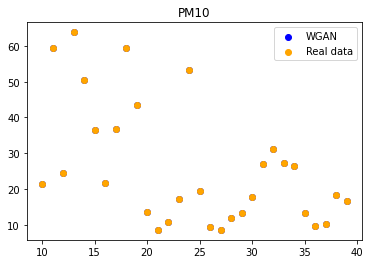

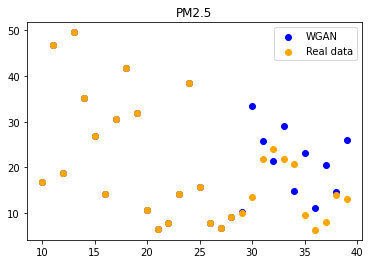

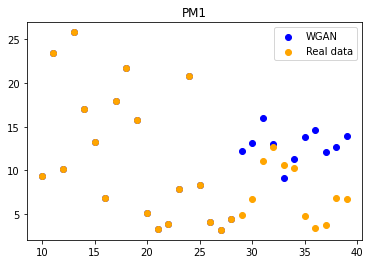

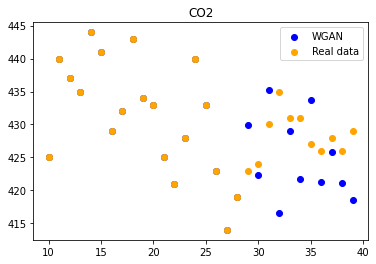

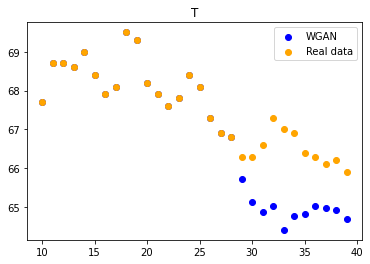

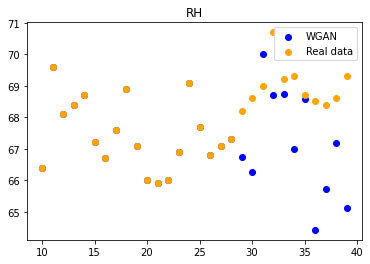

In [11]:
if fixed_input:
    pred_out = predict_fixed_continuous(df, 0, 100, ntimes, nvars, netG, INPUT_DIM, LATENT_DIM, use_cuda)
    np.save(TMP_PATH + 'pred_out.npy', pred_out)

    end_index = pred_out.shape[0]
    plot_time_predictions(df[:end_index, :], pred_out[:end_index, :], eph)